In [4]:
import pandas as pd
pd.options.display.max_columns=999
pd.options.display.max_rows=999
import pandas_profiling
from collections import Counter, defaultdict
import re
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
%reload_ext autoreload
%autoreload 2
from tqdm import tqdm_notebook, trange
import pickle
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
from glob import glob
from itertools import chain
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
import datetime
import os
from pythainlp import word_tokenize

In [162]:
review_df = pd.read_csv('src/amzn_fake_review_star_correct_302066.csv')

In [163]:
review_df.head()

,review_id,en_segment,th_segment,correct,review_star
0,1-333090,Good quality product at reasonable price.,สินค้าคุณภาพดีในราคาที่เหมาะสม,1.0,4.0
1,1-57783,They do NOT last more than 10 bottles.,พวกเขาไม่เกิน 10 ขวด,0.0,1.0
2,1-319174,If you like post-apocalyptic fiction with a tw...,ถ้าคุณชอบนิยายหลังเลิกเรียนด้วยการบิดนี่คือมัน,0.0,4.0
3,1-425331,Was a little worried when purchasing due to so...,รู้สึกกังวลเล็กน้อยเมื่อซื้อเนื่องจากรีวิวบางอ...,0.0,4.0
4,1-134583,I had heard from relatives who have read this ...,ฉันได้ยินจากญาติที่อ่านหนังสือเล่มนี้ว่าพ่อแม่...,1.0,2.0


In [164]:
review_df.shape

(302066, 5)

# Explore data

In [165]:
# show random en_segment / th_segment
rand_idx = np.random.randint(len(review_df))
print('Eng comment: {}\n\nThai comment: {}\n\nis_correct: {}\nreview star:{}'\
      .format(review_df.iloc[rand_idx]['en_segment'],
      review_df.iloc[rand_idx]['th_segment'],
      review_df.iloc[rand_idx]['correct'],
      review_df.iloc[rand_idx]['review_star']))

Eng comment: I didn't even finish this book.There wasn't enough in it to keep my interest and there was no character development.The language is stilted, the setting confusing.All of these factors just made me feel like reading about some people drinking a lot.Not much happening here.Just lots of drinking, which doesn't do anything to show me how interesting any scene is.It really felt more like a bunch of vignettes edited together.

Thai comment: ฉันยังไม่จบหนังสือเล่มนี้มีไม่เพียงพอที่จะรักษาความสนใจของฉันและไม่มีการพัฒนาตัวละครภาษาหยิ่งทะนงการตั้งค่าทำให้สับสนปัจจัยทั้งหมดเหล่านี้ทำให้ฉันรู้สึกอยากอ่านเกี่ยวกับบางคนดื่มมากไม่ค่อยเกิดขึ้นที่นี่ดื่มมากมายซึ่งไม่ได้ทำอะไรเลยเพื่อแสดงให้ฉันเห็นว่าฉากไหนน่าสนใจมันให้ความรู้สึกเหมือนเป็นบทความสั้น ๆ ที่แก้ไขร่วมกัน

is_correct: 1.0
review star:2.0


In [166]:
review_df.isna().sum()

review_id      0
en_segment     0
th_segment     0
correct        0
review_star    0
dtype: int64

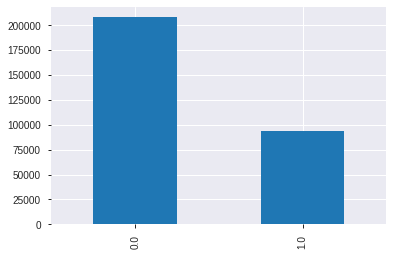

In [167]:
review_df['correct'].value_counts().plot(kind='bar')

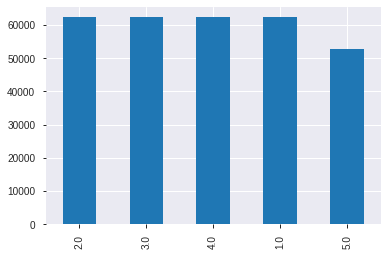

In [168]:
review_df['review_star'].value_counts().plot(kind='bar')

In [9]:
def customized_process_thai(s):
    # pre-rule
    ps = [re.compile(r'\s\.+'),re.compile(r'\s\-+'),re.compile(r'&.*?;')]
    for p in ps: s = p.sub('',s)
    
    # tokenize
    tokens = word_tokenize(s,engine='newmm')
    
    return '|'.join(tokens)

In [10]:
review_df["processed"] = [customized_process_thai(txt) for txt in tqdm_notebook(review_df['th_segment'].values)]
review_df["wc"] = review_df['processed'].map(lambda x: len(x.split("|")))
review_df["uwc"] = review_df['processed'].map(lambda x: len(set(x.split("|"))))

In [2]:
# save tokenized review
os.makedirs('tmp',exist_ok=True)
# review_df.to_csv('tmp/review_df_custom_processor_check-point-1.csv',index=False)

# review_df = pd.read_csv('tmp/review_df_custom_processor_check-point-1.csv.csv')

In [170]:
review_df.head()

,review_id,en_segment,th_segment,correct,review_star
0,1-333090,Good quality product at reasonable price.,สินค้าคุณภาพดีในราคาที่เหมาะสม,1.0,4.0
1,1-57783,They do NOT last more than 10 bottles.,พวกเขาไม่เกิน 10 ขวด,0.0,1.0
2,1-319174,If you like post-apocalyptic fiction with a tw...,ถ้าคุณชอบนิยายหลังเลิกเรียนด้วยการบิดนี่คือมัน,0.0,4.0
3,1-425331,Was a little worried when purchasing due to so...,รู้สึกกังวลเล็กน้อยเมื่อซื้อเนื่องจากรีวิวบางอ...,0.0,4.0
4,1-134583,I had heard from relatives who have read this ...,ฉันได้ยินจากญาติที่อ่านหนังสือเล่มนี้ว่าพ่อแม่...,1.0,2.0


# Train/valid split

In [13]:
train_df, valid_df = train_test_split(review_df, test_size=0.20, random_state=1)
train_df = train_df.reset_index(drop=True)

# further split validation to validation & test
valid_df, test_df = train_test_split(valid_df, test_size=0.50, random_state=11)
valid_df = valid_df.reset_index(drop=True)
test_df = test_df.reset_index(drop=True)

train_df.shape, valid_df.shape, test_df.shape

((241652, 8), (30207, 8), (30207, 8))

In [14]:
# prevalence
train_df["correct"].value_counts(normalize=True)

0.0    0.689533
1.0    0.310467
Name: correct, dtype: float64

In [15]:
# prevalence
valid_df["correct"].value_counts(normalize=True)

0.0    0.682822
1.0    0.317178
Name: correct, dtype: float64

Save train/valid/test set

In [24]:
# train_df.to_csv('src/amazon_train.csv',index=False)
# valid_df.to_csv('src/amazon_valid.csv',index=False)
# test_df.to_csv('src/amazon_test.csv',index=False)

train_df = pd.read_csv('src/amazon_train.csv')
valid_df = pd.read_csv('src/amazon_valid.csv')
test_df = pd.read_csv('src/amazon_test.csv')

In [25]:
# create separate train + valid data called all df
all_df = pd.concat([train_df,valid_df],axis=0)
all_df.reset_index(drop=True, inplace=True)

In [26]:
all_df.shape

(271859, 8)

In [28]:
all_df.head()

,review_id,en_segment,th_segment,correct,review_star,processed,wc,uwc
0,1-105256,The writing seems stilted and the characters a...,ดูเหมือนว่าการเขียนจะโอ้อวดและตัวละครไม่น่าสนใ...,0.0,2.0,ดูเหมือนว่า|การเขียน|จะ|โอ้อวด|และ|ตัวละคร|ไม่...,88,69
1,2-38709,We bought these for our 3 year old son to acco...,เราซื้อสิ่งเหล่านี้ให้กับลูกชายวัย 3 ขวบของเรา...,0.0,4.0,เรา|ซื้อ|สิ่ง|เหล่านี้|ให้|กับ|ลูกชาย|วัย| |3|...,43,33
2,1-399475,"this movie was fun and funny, I loved it from ...",หนังเรื่องนี้สนุกและตลกมากฉันชอบมันตั้งแต่ต้นจ...,0.0,4.0,หนัง|เรื่อง|นี้|สนุก|และ|ตลก|มาก|ฉัน|ชอบ|มัน|ต...,24,23
3,2-31276,"The book has a lot of helpful tips, but is lac...",หนังสือเล่มนี้มีเคล็ดลับที่เป็นประโยชน์มากมาย ...,0.0,2.0,หนังสือ|เล่ม|นี้|มี|เคล็ดลับ|ที่|เป็นประโยชน์|...,76,64
4,2-11047,I like the author however this book did was no...,ฉันชอบผู้แต่ง แต่หนังสือเล่มนี้ไม่ได้ขึ้นอยู่ก...,0.0,1.0,ฉัน|ชอบ|ผู้แต่ง| |แต่|หนังสือ|เล่ม|นี้|ไม่ได้|...,40,34


# Preprocess data

## Word level text feature

In [6]:
from collections import defaultdict

In [7]:
# select vocabs with given minimum freq
def get_tokens_from_processed_text(df_col:pd.Series):
    return [toks_str.split('|') for toks_str in df_col.values.tolist()]

tokens_train = get_tokens_from_processed_text(train_df['processed'])
tokens_valid = get_tokens_from_processed_text(valid_df['processed'])
tokens_test = get_tokens_from_processed_text(test_df['processed'])

mcn = Counter(chain(*tokens_train)).most_common()
freq = np.array(list(zip(*mcn))[1])
cut_idx = len(freq[freq>2])
vocabs = list(zip(*mcn))[0][:cut_idx]

In [8]:
# create encoder/decoder for vocabs --> start at 1 and leave 0 for padding and 1 for unknnown
stoi = defaultdict(lambda:1 ,{vocab:i for i,vocab in enumerate(vocabs,2)})
itos = defaultdict(lambda:1 ,{i:vocab for i,vocab in enumerate(vocabs,2)})

In [ ]:
from tqdm import tqdm_notebook
# filter tokens
def filter_tokens(tokens, vocabs):
    return [[tkn for tkn in tkns if tkn in vocabs] for tkns in tqdm_notebook(tokens)]

tokens_train = filter_tokens(tokens_train,vocabs)
tokens_valid = filter_tokens(tokens_valid,vocabs)
tokens_test = filter_tokens(tokens_test,vocabs)

def encode_tokens(tokens, stoi):
    return [[stoi[tkn] for tkn in tkns] for tkns in tokens]

# encode tokens
tokens_train_enc = encode_tokens(tokens_train,stoi)
tokens_valid_enc = encode_tokens(tokens_valid,stoi)
tokens_test_enc = encode_tokens(tokens_test,stoi)

In [ ]:
# check tokens length
tokens_len = np.array([len(tokens) for tokens in tokens_train])
_ = plt.hist(tokens_len)
np.percentile(tokens_len, [25,50,75])

In [ ]:
def zero_padding(enc_tokens,seq_length):
    '''
    function as written in in https://github.com/udacity/deep-learning-v2-pytorch/blob/master/sentiment-rnn/Sentiment_RNN_Solution.ipynb
    '''
    features = np.zeros((len(enc_tokens),seq_length),dtype=int)
    
    for i, toks in enumerate(enc_tokens):
        if len(toks)>0: features[i, -len(toks):] = np.array(toks)[:seq_length]
        
    return features

# zero padding
text_feat_train = zero_padding(tokens_train_enc, 100)
text_feat_valid = zero_padding(tokens_valid_enc, 100)
text_feat_test = zero_padding(tokens_test_enc, 100)

In [ ]:
text_feat_train.shape, text_feat_valid.shape, text_feat_test.shape

## Character level text feature

In [ ]:
def get_char_tokens(processed_df_col: pd.Series):
    return [list(''.join(txt.split('|'))) for txt in processed_df_col.values]

tokens_char_train = get_char_tokens(train_df['processed'])
tokens_char_valid = get_char_tokens(valid_df['processed'])
tokens_char_test = get_char_tokens(test_df['processed'])

In [ ]:
_ = plt.hist([len(toks) for toks in tokens_char_train])

In [ ]:
chars = list(set(chain(*tokens_char_train)))

In [ ]:
len(chars)

In [ ]:
# create encoder/decoder for characters --> start at 2 and leave 0 for padding and 1 for unknnown
ctoi = defaultdict(lambda: 1,{char:i for i,char in enumerate(chars,2)})
itoc = defaultdict(lambda: 1,{i:char for i,char in enumerate(chars,2)})

In [ ]:
# encode tokens
tokens_char_train_enc = encode_tokens(tokens_char_train,ctoi)
tokens_char_valid_enc = encode_tokens(tokens_char_valid,ctoi)
tokens_char_test_enc = encode_tokens(tokens_char_test,ctoi)

In [ ]:
# zero padding
char_feat_train = zero_padding(tokens_char_train_enc, 400)
char_feat_valid = zero_padding(tokens_char_valid_enc, 400)
char_feat_test = zero_padding(tokens_char_test_enc, 400)

In [ ]:
char_feat_train.shape, char_feat_valid.shape, char_feat_test.shape

## Numerical feature

In [87]:
# get numeric feat --> just use the original word count & unique word count
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
num_cols = ['wc','uwc']
num_feat_train = scaler.fit_transform(train_df[num_cols].values)
num_feat_valid = scaler.transform(valid_df[num_cols].values)
num_feat_test = scaler.transform(test_df[num_cols].values)

In [88]:
num_feat_train.shape, num_feat_valid.shape, num_feat_test.shape

((241652, 2), (30207, 2), (30207, 2))

## Targets

In [89]:
from sklearn.preprocessing import LabelEncoder

targ1_col = 'correct'
targ1_train = train_df[targ1_col].values
targ1_valid = valid_df[targ1_col].values
targ1_test = test_df[targ1_col].values

targ2_col = 'review_star'
label_enc = LabelEncoder()

targ2_train = label_enc.fit_transform(train_df[targ2_col].values)
targ2_valid = label_enc.transform(valid_df[targ2_col].values)
targ2_test = label_enc.transform(test_df[targ2_col].values)

Check-point

In [5]:
import pickle

# pickle.dump(text_feat_train,open('tmp/text_feat_train.pkl','wb'))
# pickle.dump(text_feat_valid,open('tmp/text_feat_valid.pkl','wb'))
# pickle.dump(text_feat_test,open('tmp/text_feat_test.pkl','wb'))

# pickle.dump(char_feat_train,open('tmp/char_feat_train.pkl','wb'))
# pickle.dump(char_feat_valid,open('tmp/char_feat_valid.pkl','wb'))
# pickle.dump(char_feat_test,open('tmp/char_feat_test.pkl','wb'))

# pickle.dump(num_feat_train,open('tmp/num_feat_train.pkl','wb'))
# pickle.dump(num_feat_valid,open('tmp/num_feat_valid.pkl','wb'))
# pickle.dump(num_feat_test,open('tmp/num_feat_test.pkl','wb'))

# pickle.dump(targ1_train,open('tmp/targ1_train.pkl','wb'))
# pickle.dump(targ1_valid,open('tmp/targ1_valid.pkl','wb'))
# pickle.dump(targ1_test,open('tmp/targ1_test.pkl','wb'))

# pickle.dump(targ2_train,open('tmp/targ2_train.pkl','wb'))
# pickle.dump(targ2_valid,open('tmp/targ2_valid.pkl','wb'))
# pickle.dump(targ2_test,open('tmp/targ2_test.pkl','wb'))

# pickle.dump(vocabs,open('tmp/vocab.pkl','wb'))

# pickle.dump(chars,open('tmp/chars.pkl','wb'))

text_feat_train = pickle.load(open('tmp/text_feat_train.pkl','rb'))
text_feat_valid = pickle.load(open('tmp/text_feat_valid.pkl','rb'))
text_feat_test = pickle.load(open('tmp/text_feat_test.pkl','rb'))

char_feat_train = pickle.load(open('tmp/char_feat_train.pkl','rb'))
char_feat_valid = pickle.load(open('tmp/char_feat_valid.pkl','rb'))
char_feat_test = pickle.load(open('tmp/char_feat_test.pkl','rb'))

num_feat_train = pickle.load(open('tmp/num_feat_train.pkl','rb'))
num_feat_valid = pickle.load(open('tmp/num_feat_valid.pkl','rb'))
num_feat_test = pickle.load(open('tmp/num_feat_test.pkl','rb'))

targ1_train = pickle.load(open('tmp/targ1_train.pkl','rb'))
targ1_valid = pickle.load(open('tmp/targ1_valid.pkl','rb'))
targ1_test = pickle.load(open('tmp/targ1_test.pkl','rb'))

targ2_train = pickle.load(open('tmp/targ2_train.pkl','rb'))
targ2_valid = pickle.load(open('tmp/targ2_valid.pkl','rb'))
targ2_test = pickle.load(open('tmp/targ2_test.pkl','rb'))

vocabs = pickle.load(open('tmp/vocab.pkl','rb'))

chars = pickle.load(open('tmp/chars.pkl','rb'))

# Model

## Customised RNN based model

In [10]:
import torch
from torch import nn

In [11]:
# input dtypes: text -> long, numeric -> double
in_dtypes = [torch.long, torch.double]
# output dtypes: binary classification targ -> double (as probability), n class classification targ -> long
targ_dtypes = [torch.double, torch.long]

train_ds = UniversalDataset(ins=[text_feat_train, num_feat_train],
              in_dtypes=in_dtypes,
              targs=[targ1_train[:,None], targ2_train],
              targ_dtypes=targ_dtypes)

valid_ds = UniversalDataset(ins=[text_feat_valid, num_feat_valid],
                           in_dtypes=in_dtypes,
                           targs=[targ1_valid[:,None], targ2_valid],
                           targ_dtypes=targ_dtypes)

test_ds = UniversalDataset(ins=[text_feat_test, num_feat_test],
                          in_dtypes=in_dtypes,
                          targs = [targ1_test[:,None], targ2_test],
                          targ_dtypes = targ_dtypes)

bs = 256
train_dl = DataLoader(train_ds, batch_size=bs, shuffle=True)
valid_dl = DataLoader(valid_ds, batch_size=bs, shuffle=False)
test_dl = DataLoader(test_ds, batch_size=bs, shuffle=False)

data_train = DataBunch(train_dl, valid_dl)

In [12]:
from pytorch_wrapper.container import *
from pytorch_wrapper.callback import *
from cto_ds_utilities.tabular_nn import *
import torch.nn.functional as F

from torch.utils.data import ConcatDataset

In [13]:
# stack train & valid data then retrain on whole data
all_ds = ConcatDataset([train_ds,valid_ds])
all_dl = DataLoader(all_ds,batch_size=bs, shuffle=True)
# all_dl_ = DataLoader(all_ds,batch_size=bs, shuffle = False)
data_all = DataBunch(all_dl, None)

In [14]:
class FocalLoss(nn.Module):
    def __init__(self, gamma):
        super().__init__()
        self.gamma = gamma
        
    def forward(self, input, target):
        # Inspired by the implementation of binary_cross_entropy_with_logits
        if not (target.size() == input.size()):
            raise ValueError("Target size ({}) must be the same as input size ({})".format(target.size(), input.size()))

        max_val = (-input).clamp(min=0)
        loss = input - input * target + max_val + ((-max_val).exp() + (-input - max_val).exp()).log()

        # This formula gives us the log sigmoid of 1-p if y is 0 and of p if y is 1
        invprobs = F.logsigmoid(-input * (target * 2 - 1))
        loss = (invprobs * self.gamma).exp() * loss
        
        return loss.mean()

def accuracy_binary(out, yb): return ((torch.sigmoid(out)>.5).float()==yb).float().mean()

def accuracy_categorical(out, yb): return (torch.argmax(out, dim=1)==yb).float().mean()

In [15]:
loss_func1 = FocalLoss(gamma=.5)
loss_func2 = nn.CrossEntropyLoss()

multi_loss_func = MultitasksLoss([loss_func1, loss_func2])

In [16]:
metric1 = accuracy_binary
metric2 = accuracy_categorical

In [18]:
class Attention(nn.Module):
    # borrow from: https://github.com/mttk/rnn-classifier/blob/master/model.py
    
    def __init__(self, query_dim, key_dim, value_dim):
        super(Attention, self).__init__()
        self.scale = 1. / math.sqrt(query_dim)

    def forward(self, query, keys, values):
        # Query = [BxQ]
        # Keys = [TxBxK]
        # Values = [TxBxV]
        # Outputs = a:[TxB], lin_comb:[BxV]

        # Here we assume q_dim == k_dim (dot product attention)

        query = query.unsqueeze(1) # [BxQ] -> [Bx1xQ]
#         keys = keys.transpose(0,1).transpose(1,2) # [TxBxK] -> [BxKxT]
        keys = keys.transpose(-1,1)
#         print(f'query: {query.shape} keys:{keys.shape}')
        energy = torch.bmm(query, keys) # [Bx1xQ]x[BxKxT] -> [Bx1xT]
        energy = F.softmax(energy.mul_(self.scale), dim=2) # scale, normalize
#         print(f'energy: {energy.shape} values: {values.shape}')
#         values = values.transpose(0,1) # [TxBxV] -> [BxTxV]
        
        linear_combination = torch.bmm(energy, values).squeeze(1) #[Bx1xT]x[BxTxV] -> [BxV]
#         print(f'linear_combination: {linear_combination.shape}')
        return energy, linear_combination

class AmazonMultiTaskAttn(nn.Module):

    def __init__(self, **config):
        super(AmazonMultiTaskAttn, self).__init__()

        # store config
        self.config = config
        # store current device
        self.device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

        # numerical feat projector
        self.num_proj = nn.Sequential(nn.Linear(config['n_num'],config['num_dim']),
                                      nn.BatchNorm1d(config['num_dim'])
                                     )
        
        # embedding layers
        self.word_emb = nn.Embedding(config['vocab_size'] + 2, config['emb_size'])

        # rnn layers
        self.rnn = nn.GRU(input_size=config['emb_size'], hidden_size=config['rnn_h'],
                           num_layers=config['rnn_l'], batch_first=True, bidirectional=True)

        # self-attention
        self.attention = Attention(config['rnn_h']*2,config['rnn_h']*2,config['rnn_h']*2)
        
        # fc layers
        self.lin_in = config['num_dim'] + config['rnn_h'] * 2
        self.fc_sizes = [self.lin_in] + config['fc_sizes']

        fc_layers_list = []
        for ni, nf, p in zip(self.fc_sizes[:-1], self.fc_sizes[1:], config['fc_ps']):
            fc_layers_list.append(nn.Linear(ni, nf))
            fc_layers_list.append(nn.ReLU(inplace=True))
            fc_layers_list.append(nn.BatchNorm1d(nf))
            fc_layers_list.append(nn.Dropout(p=p))
        self.fc_layers = nn.Sequential(*fc_layers_list)

        # output heads by task
        self.heads = nn.ModuleList([nn.Linear(self.fc_sizes[-1], out_size) for out_size in config['out_sizes']])
        
    def forward(self, ins):
        text, num = ins
        text, num = text.to(self.device), num.to(self.device)

        # numeric
        num_out = self.num_proj(num)
        
        # text
        text_out = self.word_emb(text)
        rnn_outs, rnn_hidden = self.rnn(text_out)
#         print(f'rnn_outs:{rnn_outs.shape} rnn_hidden:{rnn_hidden.shape}')
        rnn_hidden = torch.cat([rnn_hidden[-1], rnn_hidden[-2]], dim=1)
#         print(f'rnn_hidden:{rnn_hidden.shape}')
        energy, text_out = self.attention(rnn_hidden, rnn_outs, rnn_outs)

        # concat
        lin_in = torch.cat([text_out, num_out], 1)

        # fc forward
        fc_out = self.fc_layers(lin_in)
        head_outs = [head(fc_out) for head in self.heads]

        return head_outs

In [119]:
config = {'vocab_size': len(vocabs),'emb_size': 400, 'rnn_h': 300,
        'rnn_l': 2, 'fc_ps': [0.5, 0.5], 'n_num':2, 'num_dim':100 , 'fc_sizes': [1000, 500], 'out_sizes': [1,5]}

model = AmazonMultiTaskAttn(**config).double()

In [120]:
_ = model.to(model.device)

In [121]:
# test model with data
model(next(iter(train_dl))[0])[0].shape, model(next(iter(train_dl))[0])[1].shape

(torch.Size([256, 1]), torch.Size([256, 5]))

In [122]:
config = {'vocab_size': len(vocabs),'emb_size': 400, 'rnn_h': 300,
        'rnn_l': 2, 'fc_ps': [0.5, 0.5], 'n_num':2, 'num_dim':100 , 'fc_sizes': [1000, 500], 'out_sizes': [1,5]}

model = AmazonMultiTaskAttn(**config).double()
_ = model.to(model.device)

multi_loss_func = MultitasksLoss([loss_func1, loss_func2],loss_weights=[.6,.4])
opt = optim.Adam(model.parameters(),lr=1e-3)

learner = Learner(model=model, data=data_train, loss_func=multi_loss_func, optimizer=opt, cbfs=cbfs)

cbfs = [partial(AvgStatsCallback,[metric1, metric2])]

max_lr=1e-3
sched_lr = combine_scheds([0.3, 0.7], [sched_cos(max_lr/5,max_lr),sched_cos(max_lr,max_lr/10)])
sched_beta1 = combine_scheds([0.3, 0.7], [sched_cos(0.9, 0.8), sched_cos(0.8, 0.9)])
sched_beta2 = combine_scheds([0.3, 0.7], [sched_cos(0.99, 0.9), sched_cos(0.9, 0.99)])
def sched_betas(pos): return [sched_beta1(pos), sched_beta2(pos)]

sched_dict = {'lr':sched_lr, 'betas': sched_betas}
learner.fit_with_sched(3,sched_dict)

epoch 1-train: [0.7433645853325621, tensor(0.6780, device='cuda:0'), tensor(0.4761, device='cuda:0')]
epoch 1-valid: [0.6592615903416682, tensor(0.7061, device='cuda:0'), tensor(0.5489, device='cuda:0')]
epoch 2-train: [0.6238996603507941, tensor(0.7160, device='cuda:0'), tensor(0.5906, device='cuda:0')]
epoch 2-valid: [0.6139034271199542, tensor(0.7136, device='cuda:0'), tensor(0.6032, device='cuda:0')]
epoch 3-train: [0.5431565020957869, tensor(0.7300, device='cuda:0'), tensor(0.6794, device='cuda:0')]
epoch 3-valid: [0.5989208946867739, tensor(0.7164, device='cuda:0'), tensor(0.6351, device='cuda:0')]


### Train with all data

In [19]:
config = {'vocab_size': len(vocabs),'emb_size': 400, 'rnn_h': 300,
        'rnn_l': 2, 'fc_ps': [0.5, 0.5], 'n_num':2, 'num_dim':100 , 'fc_sizes': [1000, 500], 'out_sizes': [1,5]}

model = AmazonMultiTaskAttn(**config).double()
_ = model.to(model.device)

multi_loss_func = MultitasksLoss([loss_func1, loss_func2],loss_weights=[.6,.4])
opt = optim.Adam(model.parameters(),lr=1e-3)

cbfs = [partial(AvgStatsCallback,[metric1, metric2])]

learner = Learner(model=model, data=data_all, loss_func=multi_loss_func, optimizer=opt, cbfs=cbfs)

max_lr=1e-3
sched_lr = combine_scheds([0.3, 0.7], [sched_cos(max_lr/5,max_lr),sched_cos(max_lr,max_lr/10)])
sched_beta1 = combine_scheds([0.3, 0.7], [sched_cos(0.9, 0.8), sched_cos(0.8, 0.9)])
sched_beta2 = combine_scheds([0.3, 0.7], [sched_cos(0.99, 0.9), sched_cos(0.9, 0.99)])
def sched_betas(pos): return [sched_beta1(pos), sched_beta2(pos)]

sched_dict = {'lr':sched_lr, 'betas': sched_betas}
learner.fit_with_sched(3,sched_dict)

epoch 1-train: [0.7380565785069271, tensor(0.6797, device='cuda:0'), tensor(0.4823, device='cuda:0')]
epoch 2-train: [0.6197548010921846, tensor(0.7161, device='cuda:0'), tensor(0.5955, device='cuda:0')]
epoch 3-train: [0.5362411390583282, tensor(0.7308, device='cuda:0'), tensor(0.6870, device='cuda:0')]


Get test accuracy

In [ ]:
class AvgStats():
    def __init__(self, metrics, in_train): self.metrics,self.in_train = listify(metrics),in_train
    
    def reset(self):
        self.tot_loss,self.count = 0.,0
        self.tot_mets = [0.] * len(self.metrics)
        
    @property
    def all_stats(self): return [self.tot_loss.item()] + self.tot_mets
    @property
    def avg_stats(self): return [o/self.count for o in self.all_stats]
    
    def __repr__(self):
        if not self.count: return ""
        return f"{'train' if self.in_train else 'valid'}: {self.avg_stats}"

    def accumulate(self, run):
        if isinstance(run.yb, Collection):
            bn = run.yb[0].shape[0]
        else:
            bn = run.yb.shape[0]

        self.tot_loss += run.loss * bn
        self.count += bn
        for i,m in enumerate(self.metrics):
            self.tot_mets[i] += m(run.pred[i], run.yb[i]) * bn

In [52]:
_ = model.eval()

count = 0
tot_mets = [0., 0.]
metrics = [metric1, metric2]
with torch.no_grad():
    for xb,yb in test_dl:
        pred = model(xb)
        bn = yb[0].shape[0]
        count += bn
        for i,m in enumerate(metrics):
            tot_mets[i] += m(pred[i], yb[i].to(model.device)).item() * bn
            
avg_stats = [met/count for met in tot_mets]

In [53]:
avg_stats

[0.7212566625110189, 0.6430628664006495]

## ULMFit

In [22]:
from fastai.text import *
from fastai.callbacks import CSVLogger, SaveModelCallback
from pythainlp.ulmfit import *

Download: wiki_lm_lstm
wiki_lm_lstm 0.32


thwiki_lm.pth?dl=1: 1.05GB [01:48, 9.71MB/s]                                


Download: wiki_itos_lstm
wiki_itos_lstm 0.32


thwiki_itos.pkl?dl=1: 1.53MB [00:01, 833kB/s]                            


In [60]:
os.makedirs('output', exist_ok=True)
model_path = "output/"

In [37]:
class PreprocessedTok(BaseTokenizer):
    """
    Wrapper around a frozen newmm tokenizer to make it a fastai `BaseTokenizer`.
    https://docs.fast.ai/text.transform#BaseTokenizer
    """

    def __init__(self, lang: str = "th", sep='|'):
        self.lang = lang
        self.sep = sep

    def tokenizer(self, text: str) -> List[str]:
        """
        :meth: tokenize text with a frozen newmm engine
        :param str text: text to tokenize
        :return: tokenized text
        """
        return text.split(self.sep)

    def add_special_cases(self, toks):
        pass

In [65]:
tt = Tokenizer(tok_func=PreprocessedTok, lang="th")
processor = [TokenizeProcessor(tokenizer=tt, chunksize=10_000, mark_fields=False),
            NumericalizeProcessor(vocab=None, max_vocab=30_000, min_freq=2)]

data_lm = (TextList.from_df(all_df, model_path, cols="processed", processor=processor)
    .split_by_rand_pct(valid_pct = 0.01, seed = 1412)
    .label_for_lm()
    .databunch(bs=48))
data_lm.sanity_check()

In [66]:
data_lm.save('amazon_fake_review_lm.pkl')

In [67]:
config = dict(emb_sz=400, n_hid=1550, n_layers=4, pad_token=1, qrnn=False, tie_weights=True, out_bias=True,
             output_p=0.25, hidden_p=0.1, input_p=0.2, embed_p=0.02, weight_p=0.15)
trn_args = dict(drop_mult=1., clip=0.12, alpha=2, beta=1)

learn = language_model_learner(data_lm, AWD_LSTM, config=config, pretrained=False, **trn_args)

#load pretrained models
learn.load_pretrained(**_THWIKI_LSTM)

LanguageLearner(data=TextLMDataBunch;

Train: LabelList (269141 items)
x: LMTextList
xxbos ดูเหมือนว่า การเขียน จะ โอ้อวด และ ตัวละคร ไม่ น่าสนใจ พอที่จะ ดึง ฉัน เข้ามา มี หลาย คน ที่ เป็น แบบแผน เช่น   nerd   หรือ   jerk และ พล็อต เรื่อง ต่าง ๆ   ดูเหมือน จะ ถูก วางแผน เพื่อ ความ สะดวกสบาย ของ ฉัน เรื่องราว ลาก ไป ใน สถานที่ โดยเฉพาะอย่างยิ่ง ใน บางครั้ง อาจ เป็น เพราะ ฉัน เคยชิน กับ นวนิยาย อเมริกัน สมัยใหม่ ซึ่ง มีแนวโน้ม ที่จะ เคลื่อนไหว ได้ เร็ว ขึ้น โดย ไม่ต้อง สร้าง โลก ที่ ซับซ้อน ในทางกลับกัน ตัวละคร เหล่านี้ มี ความลึก ไม่ มาก เมื่อ เทียบ กับ ที่ ฉัน มักจะ พบ    /    พบ เจอ,xxbos เรา ซื้อ สิ่ง เหล่านี้ ให้ กับ ลูกชาย วัย   3   ขวบ ของ เรา เพื่อ ติดตาม   xxmaj kindle   xxmaj fire   ใหม่ ของ เขา เพราะ เรา คิด ว่า เขา จะ กลัว ที่จะ ใช้ มัน   แต่ พวกเขา กลับ กลายเป็น ว่า ถูกต้อง ง่าย นิดเดียว,xxbos หนัง เรื่อง นี้ สนุก และ ตลก มาก ฉัน ชอบ มัน ตั้ง แต่ต้นจนจบ ภาพยนตร์ คืน วันที่ ดี เหมาะสำหรับ ผู้ ที่ ไม่ ชอบ อารมณ์ขัน หรือ ความรุนแรง,xxbos หนังสือ เล่ม นี้ มี เคล็ดลับ ที่ เป็นประ

In [68]:
print("training frozen")
learn.freeze_to(-1)
learn.fit_one_cycle(1, 1e-2, moms=(0.8, 0.7))

training frozen


epoch,train_loss,valid_loss,accuracy,time


KeyboardInterrupt: 

In [ ]:
#train unfrozen
print("training unfrozen")
learn.unfreeze()
learn.fit_one_cycle(5, 1e-3, moms=(0.8, 0.7))

In [ ]:
learn.save_encoder("amazon_thai_review_enc")

# Train classifier

In [6]:
# convert target to int for fastai to understand training task as classification
train_df['correct'] = train_df['correct'].astype(int)

#lm data
data_lm = load_data(model_path, "amazon_fake_review_lm.pkl")
data_lm.sanity_check()

#classification data
tt = Tokenizer(tok_func=ThaiTokenizer, lang="th", pre_rules=pre_rules_th, post_rules=post_rules_th)
processor = [TokenizeProcessor(tokenizer=tt, chunksize=10_000, mark_fields=False),
            NumericalizeProcessor(vocab=data_lm.vocab, max_vocab=30_000, min_freq=2)]

data_cls = (ItemLists(model_path,train=TextList.from_df(train_df, model_path, cols=["th_segment"], processor=processor),
                     valid=TextList.from_df(all_df, model_path, cols=["th_segment"], processor=processor))
    .label_from_df("correct")
    .databunch(bs=128)
    )
data_cls.sanity_check()
print(len(data_cls.vocab.itos))

In [9]:
#model
config = dict(emb_sz=400, n_hid=1550, n_layers=4, pad_token=1, qrnn=False,
             output_p=0.4, hidden_p=0.2, input_p=0.6, embed_p=0.1, weight_p=0.5)
trn_args = dict(bptt=70, drop_mult=0.7, alpha=2, beta=1, max_len=500)

learn = text_classifier_learner(data_cls, AWD_LSTM, config=config, pretrained=False, **trn_args)
#load pretrained finetuned model
learn.load_encoder("amazon_thai_review_enc")

RNNLearner(data=TextClasDataBunch;

Train: LabelList (241652 items)
x: TextList
xxbos   ดูเหมือนว่า การเขียน จะ โอ้อวด และ ตัวละคร ไม่ น่าสนใจ พอ ที่จะ ดึง ฉัน เข้ามา มี หลาย คน ที่ เป็น แบบแผน เช่น   &' nerd &'   หรือ   &' jerk &' และ พล็อต เรื่อง ต่าง   ๆ   ดูเหมือน จะ ถูก วางแผน เพื่อ ความ สะดวกสบาย ของ ฉัน เรื่องราว ลาก ไป ใน สถานที่ โดยเฉพาะอย่างยิ่ง ใน บางครั้ง อาจ เป็น เพราะ ฉัน เคยชิน กับ นวนิยาย อเมริกัน สมัยใหม่ ซึ่ง มีแนวโน้ม ที่จะ เคลื่อนไหว ได้ เร็ว ขึ้น โดย ไม่ต้อง สร้าง โลก ที่ ซับซ้อน ในทางกลับกัน ตัวละคร เหล่านี้ มี ความลึก ไม่ มาก เมื่อ เทียบ กับ ที่ ฉัน มักจะ พบ   /   พบ เจอ,xxbos   เรา ซื้อ สิ่ง เหล่านี้ ให้ กับ ลูกชาย วัย   3   ขวบ ของ เรา เพื่อ ติดตาม   kindle   fire   ใหม่ ของ เขา เพราะ เรา คิด ว่า เขา จะ กลัว ที่จะ ใช้ มัน   แต่ พวกเขา กลับ กลายเป็น ว่า ถูกต้อง ง่าย นิดเดียว,xxbos   หนัง เรื่อง นี้ สนุก และ ตลก มาก ฉัน ชอบ มัน ตั้ง แต่ต้นจนจบ ภาพยนตร์ คืน วันที่ ดี เหมาะสำหรับ ผู้ ที่ ไม่ ชอบ อารมณ์ขัน หรือ ความรุนแรง,xxbos   หนังสือ เล่ม นี้ มี เคล็ดลับ ที่ เป็

In [ ]:
learn.freeze_to(-1)
learn.fit_one_cycle(1, 2e-2)

learn.freeze_to(-2)
learn.fit_one_cycle(1, slice(2e-6 / (2.6 ** 4), 2e-6))

learn.freeze_to(-3)
learn.fit_one_cycle(1, slice(1e-6 / (2.6 ** 4), 1e-6))

learn.unfreeze()
learn.fit_one_cycle(5, slice(5e-7 / (2.6 ** 4), 5e-7),
                   callbacks=[SaveModelCallback(learn, every='improvement', monitor='accuracy', name='bestmodel')])

In [ ]:
learn.save_encoder("amazon_thai_review_enc-4")

In [ ]:
#get predictions
probs, y_true, loss = learn.get_preds(ds_type = DatasetType.Valid, ordered=True, with_loss=True)
y_true = y_true.numpy()
preds = (probs.numpy()>.5).astype(np.float)
loss = loss.numpy()

In [ ]:
to_df = np.concatenate([y_true[:,None],preds,loss[:,None],probs.numpy()],1)
probs_df = pd.DataFrame(to_df)
probs_df.columns = ['true','pred','loss','prob']
probs_df["hit"] = (probs_df['true'] == probs_df['pred'])
probs_df["text"] = valid_df['th_segment']
(y_true==preds).mean()

# Logistic regression

In [4]:
#dependent variables
y_train = train_df["correct"]
y_valid = valid_df["correct"]

In [5]:
#text faetures
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression

In [6]:
tfidf = TfidfVectorizer(tokenizer=lambda x:x.split('|'), ngram_range=(1,2), max_features=25_000, sublinear_tf=True)
tfidf.fit(pd.concat([train_df,valid_df],axis=0)["processed"])
text_train = tfidf.transform(train_df["processed"])
text_valid = tfidf.transform(valid_df["processed"])
text_test = tfidf.transform(test_df["processed"])
text_train.shape, text_valid.shape

/opt/conda/lib/python3.7/site-packages/sklearn/feature_extraction/text.py:507: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn("The parameter 'token_pattern' will not be used"


TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.float64'>, encoding='utf-8',
                input='content', lowercase=True, max_df=1.0, max_features=20000,
                min_df=1, ngram_range=(1, 2), norm='l2', preprocessor=None,
                smooth_idf=True, stop_words=None, strip_accents=None,
                sublinear_tf=True, token_pattern='(?u)\\b\\w\\w+\\b',
                tokenizer=<function <lambda> at 0x7fc7639590e0>, use_idf=True,
                vocabulary=None)

((241652, 20000), (30207, 20000))

In [7]:
#word count and unique word counts; actually might not be so useful
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler.fit(pd.concat([train_df,valid_df],axis=0)[["wc","uwc"]].astype(float))
print(scaler.mean_, scaler.var_)
num_train = scaler.transform(train_df[["wc","uwc"]].astype(float))
num_valid = scaler.transform(valid_df[["wc","uwc"]].astype(float))
num_test = scaler.transform(test_df[["wc","uwc"]].astype(float))
num_train.shape, num_valid.shape

StandardScaler(copy=True, with_mean=True, with_std=True)

[55.35855351 46.01925263] [651.70895073 381.49864169]


((241652, 2), (30207, 2))

In [ ]:
#concatenate text and word count features
X_train = np.concatenate([num_train,text_train.toarray()],axis=1)
X_valid = np.concatenate([num_valid,text_valid.toarray()],axis=1)
X_test = np.concatenate([num_test,text_test.toarray()],axis=1)
X_train.shape, X_valid.shape

In [12]:
#fit logistic regression models
model = LogisticRegression(C=2., penalty="l2", solver="liblinear", dual=False, multi_class="ovr")
model.fit(X_train,y_train)
model.score(X_valid,y_valid)

LogisticRegression(C=2.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='ovr', n_jobs=None, penalty='l2',
                   random_state=None, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)

0.7160450231736923

In [14]:
probs = model.predict_proba(X_valid)
probs_df = pd.DataFrame(probs)
probs_df.columns = model.classes_
probs_df["preds"] = model.predict(X_valid)
probs_df["correct"] = valid_df['correct']
probs_df["th_segment"] = valid_df['th_segment']
probs_df["processed"] = valid_df['processed']
probs_df["wc"] = valid_df['wc']
probs_df["uwc"] = valid_df['uwc']
probs_df["hit"] = (probs_df['preds']==probs_df['correct'])
probs_df.to_csv("tmp/probs_df_linear.csv", index=False)

In [15]:
probs_df.head()

,0.0,1.0,preds,correct,th_segment,processed,wc,uwc,hit
0,0.807132,0.192868,0.0,1.0,เหตุผลเดียวที่ทำให้มันได้รับสามดาวก็เพราะว่ามั...,เหตุผล|เดียว|ที่|ทำให้|มัน|ได้รับ|สาม|ดาว|ก็เพ...,50,43,False
1,0.665240,0.334760,0.0,1.0,ซื้อและลองสิ่งนี้เมื่อหน่วยเก่าของฉันล้มเหลว (...,ซื้อ|และ|ลอง|สิ่ง|นี้|เมื่อ|หน่วย|เก่า|ของ|ฉัน...,28,28,False
2,0.272429,0.727571,1.0,0.0,ฉันดีใจที่ฉันไม่ได้จ่ายอะไรเลย,ฉัน|ดีใจ|ที่|ฉัน|ไม่ได้|จ่าย|อะไร|เลย,8,7,False
3,0.864635,0.135365,0.0,0.0,ไม่ชอบสไตล์การเขียนของผู้เขียนรู้สึกว่ามันสื่อ...,ไม่|ชอบ|สไตล์|การเขียน|ของ|ผู้เขียน|รู้สึก|ว่า...,83,71,True
4,0.915618,0.084382,0.0,0.0,ฉันมีสุนัขตัวใหญ่มาก - £ 12 และปลอกคอนี้จะไม่พ...,ฉัน|มี|สุนัข|ตัว|ใหญ่|มาก|-|£|12|และ|ปลอกคอ|นี...,73,55,True


0.7160450231736923


Text(30.5, 0.5, 'Actual')

Text(0.5, 12.5, 'Predicted')

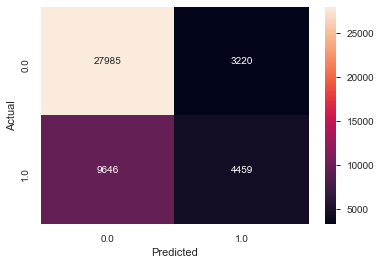

In [17]:
from sklearn.metrics import confusion_matrix

conf_mat = confusion_matrix(probs_df['correct'],probs_df['preds'])
print(model.score(X_valid,y_valid))
sns.heatmap(conf_mat, annot=True, fmt="d",
            xticklabels=model.classes_, yticklabels=model.classes_)
plt.ylabel("Actual")
plt.xlabel("Predicted")
plt.show()